# Task A1 - Gender Detection
by MOHAMED AZMIL IRFAN MOHAMED AMIRUDDIN

(AMLS 19/20 ASSIGNMENT)

## Import Libraries

In [1]:
import os
import cv2
import dlib
import numpy as np
import pandas as pd
from pandas import DataFrame
from keras.preprocessing import image
from sklearn import svm
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt

%matplotlib inline
# required magic function

# import sys
# np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.
C:\Users\Bear-\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Bear-\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Bear-\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Bear-\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

## Change directory to one level up
relevant folder
1. Image directory : ..\AMLS_19-20_SN15053755\dataset\celeba\img
2. Label CSV file directory : ..\AMLS_19-20_SN15053755\dataset\celeba\labels.csv

In [2]:
os.chdir("..")
print(os.path.abspath(os.curdir))

C:\Users\Bear-\Desktop\AMLS_19-20_SN15053755


## Setting all directories

In [3]:
# global basedir, dataset_dir, image_paths, target_size

labels_filename = 'labels.csv'

basedir = os.path.abspath(os.curdir)
dataset_dir = os.path.join(basedir,'dataset')
celeba_dir = os.path.join(dataset_dir,'celeba')
images_dir = os.path.join(celeba_dir,'img')
labels_dir = os.path.join(celeba_dir,labels_filename)

# print(os.path.abspath(images_dir))

In [4]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

## Feature Extraction function

In [5]:
def extract_features_labels(images_dir, labels_dir):
    """ return:
        landmark_features:  an array containing 68 landmark points for each image in celeba folder
        gender_labels:      an array containing the gender label (male=0 and female=1) for each image
    """
    image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)] ##filename in matrix
    target_size = None
    labels_file = open(labels_dir, 'r')
    lines = labels_file.readlines()
    gender_labels = {line.split('\t')[0] : int(line.split('\t')[2]) for line in lines[1:]} ##fetch filename + label gender
    if os.path.isdir(images_dir):
        all_features = []
        all_labels = []
        error_features = []
        for img_path in image_paths:
            file_name= img_path.split('.')[0].split('\\')[-1] ##getting name of file; remove png/jpg + dir

            # load image
            img = image.img_to_array(
                image.load_img(img_path,
                               target_size=target_size,
                               interpolation='bicubic'))
            features, _ = run_dlib_shape(img)
            if features is not None:
                all_features.append(features)
                all_labels.append(gender_labels[file_name])
            if features is None:
                error_features.append(file_name)
                

    landmark_features = np.array(all_features)
    gender_labels = (np.array(all_labels) + 1)/2 # converts the -1 into 0, so male=0 and female=1
    return landmark_features, gender_labels, error_features

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)


def run_dlib_shape(image):
    # in this function we load the image, detect the landmarks of the face, and then return the image and the landmarks
    # load the input image, resize it, and convert it to grayscale
    resized_image = image.astype('uint8')

    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    gray = gray.astype('uint8')

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    num_faces = len(rects)

    if num_faces == 0:
        return None, resized_image

    face_areas = np.zeros((1, num_faces))
    face_shapes = np.zeros((136, num_faces), dtype=np.int64)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        temp_shape = predictor(gray, rect)
        temp_shape = shape_to_np(temp_shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)],
        #   (x, y, w, h) = face_utils.rect_to_bb(rect)
        (x, y, w, h) = rect_to_bb(rect)
        face_shapes[:, i] = np.reshape(temp_shape, [136])
        face_areas[0, i] = w * h
    # find largest face and keep
    dlibout = np.reshape(np.transpose(face_shapes[:, np.argmax(face_areas)]), [68, 2])

    return dlibout, resized_image
    
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

## Testing and displaying feature extraction
Taking one image from dataset to display how feature extraction is done (ie image 11.jpg)

Jaw: [1,17]

Right Eyebrow: [18,22]

Left Eyebrow: [23,27]

Nose: [28,36]

Right Eye: [37,42]

Left Eye: [43,48]

Mouth: [49,68]

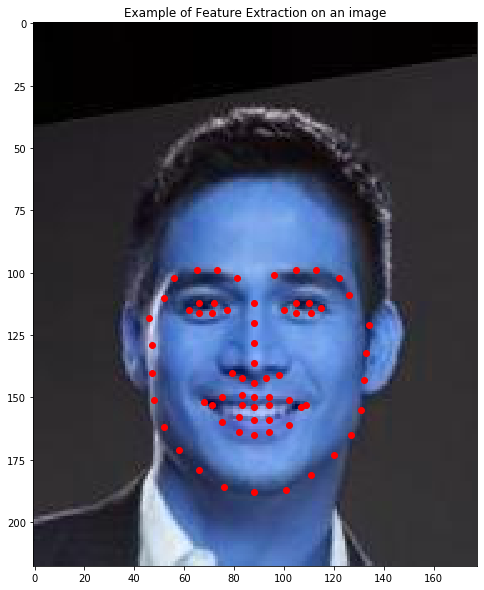

In [6]:
ex_img_path = os.path.join(images_dir, '11.jpg')
ex_image = image.img_to_array(image.load_img(ex_img_path, target_size = None, interpolation='bicubic'))
ex_feat, _ = run_dlib_shape(ex_image)

x, y  = np.split(ex_feat, 2, axis=1)
cv_image = cv2.imread(ex_img_path)
fig = plt.figure(figsize=(10,10))
image_plot = plt.imshow(cv_image)
plt.title("Example of Feature Extraction on an image")
plt.scatter(x,y, c='red')
plt.show()

The blue colour face is due to cv2 BGR default. Since colour is not relevant, hence dont need to convert to RGB

## Processing Image using Feature Extraction

In [7]:
feature, label, error = extract_features_labels(images_dir, labels_dir)

print(len(feature))
print(len(label))

4800
4800


As it can be seen, not every picture can be feature extraction. This maybe due to the image is not front-faced or not clear

In [8]:
print("Number of error images :")
print(len(error))
print("\n")
print("Name of error images :")
print(error)

Number of error images :
200


Name of error images :
['1015', '1037', '1045', '1109', '1119', '1153', '1162', '1183', '119', '123', '1254', '1285', '1297', '1305', '1337', '1343', '1354', '136', '137', '1400', '143', '1468', '1479', '148', '149', '1505', '1522', '153', '1532', '1558', '158', '1602', '1605', '1641', '165', '1651', '1666', '1676', '1703', '1793', '187', '1877', '1939', '1945', '1956', '198', '1994', '1997', '2', '2012', '2013', '2040', '2054', '2060', '2145', '219', '2201', '2213', '223', '2248', '2261', '2267', '2285', '2294', '2314', '2344', '2345', '2347', '239', '2416', '2447', '2480', '2486', '2512', '2582', '2605', '2622', '2631', '2696', '2728', '2828', '2851', '2919', '292', '2961', '2971', '2975', '3', '3012', '3054', '3107', '3130', '3135', '3142', '315', '3168', '3171', '3197', '3199', '3211', '3291', '330', '3319', '3382', '3399', '3454', '3492', '35', '3514', '3564', '3569', '3625', '3626', '3639', '365', '3650', '3662', '3731', '3757', '3785', '3823', '382

## Displaying some error images

In [ ]:
error_images =[]

error1 = os.path.join(images_dir, '982.jpg')
error_images.append(cv2.imread(error1))
error2 = os.path.join(images_dir, '626.jpg')
error_images.append(cv2.imread(error2))
error3 = os.path.join(images_dir, '602.jpg')
error_images.append(cv2.imread(error3))
error4 = os.path.join(images_dir, '1997.jpg')
error_images.append(cv2.imread(error4))

num_images = len(error_images)

fig =plt.figure(figsize = (10,10))
for image_idx in range(num_images):
    # Keep an incrementing count of each image
    a=fig.add_subplot(1, num_images, image_idx+1)
    # Add the image to the plot
    image_plot = plt.imshow(error_images[image_idx])
    # Add a caption with the folder name
    a.set_title("Image " + str(image_idx+1))

plt.show()

Image 1 and 2 has different orientation and not front-faced.
Image 3 is blocked.
Image 4 has shaded half the face.

## Splitting data into training and testing 

In [ ]:
def split_data(image_feature, image_label):
    i,j,k,l = train_test_split(image_feature, image_label, test_size = 0.2, random_state=42)
    train_image = i.reshape((len(i), 68*2))
#     train_image = i
    train_label = totuple(k)
    test_image = j.reshape((len(j), 68*2))
#     test_image = j
    test_label = totuple(l)
    
    return train_image, train_label, test_image, test_label

train_image, train_label, test_image, test_label = split_data(feature, label)

## Training Data

### 1. Using dummy classifier
Predicting output based on the most frequent

In [ ]:
clf_dummy = DummyClassifier(strategy= 'most_frequent').fit(train_image, train_label)
pred1 = clf_dummy.predict(test_image)
print(accuracy_score(test_label, pred1))

### 2. Using rbf kernel
Using GridSearch to optimise hyper-parameter

In [12]:
# defining parameter range 
param_grid_1 = {'C': [0.001, 0.01, 0.1, 10],  
              'gamma': [0.001, 0.01, 0.1, 1, 10], 
              'kernel': ['rbf']}

# run grid search
grid_1 = GridSearchCV(SVC(), param_grid_1, n_jobs = 4, refit = True, verbose = 3) 
grid_1 = grid_1.fit(train_image, train_label)

# set clf_rbf to best hyper-parameter
clf_rbf = grid_1.best_estimator_
clf_rbf.fit(train_image, train_label)

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.7min finished


SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [13]:
print("Best hyper-parameter tuning :")
print(grid_1.best_params_)

Best hyper-parameter tuning :
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


In [14]:
pred2 = clf_rbf.predict(test_image)
print(accuracy_score(test_label, pred2))

0.878125


### 3. Using linear kernel
Using Gridsearch to optimise hyper-parameter

In [ ]:
# defining parameter range 
param_grid_2 = {'C': [0.01, 0.1, 10],  
              'gamma': [0.001, 0.01, 0.1, 1, 10], 
              'kernel': ['linear']}

# run grid search
grid_2 = GridSearchCV(SVC(), param_grid_2, n_jobs = 4, refit = True, verbose = 3) 
grid_2 = grid_2.fit(train_image, train_label)

# set clf_rbf to best hyper-parameter
clf_lin = grid_2.best_estimator_
clf_lin.fit(train_image, train_label)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   11.7s


In [ ]:
print("Best hyper-parameter tuning :")
print(grid_2.best_params_)

In [ ]:
pred3 = clf_lin.predict(test_image)
print(accuracy_score(test_label, pred3))

### Model Validation by plotting Learning Curve

In [ ]:
newclf_rbf = SVC(C=10, gamma = 0.001, kernel='rbf')
newclf_lin = SVC(C=0.01 , gamma = 0.001, kernel = 'linear')

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y,
                                                                          cv=cv, n_jobs=n_jobs,
                                                                          train_sizes=train_sizes,
                                                                          return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt, train_scores_mean, test_scores_mean


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X = feature.reshape((len(feature), 68*2))
y = totuple(label)

title = "Learning Curves (Kernel = rbf)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = newclf_rbf
plt1, _, _ = plot_learning_curve(estimator, title, X, y, axes=axes[:, 0],
                    cv=cv, n_jobs=4)

title = r"Learning Curves (Kernel = linear)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = newclf_lin
plt2, k1,k2 = plot_learning_curve(estimator, title, X, y, axes=axes[:, 1],
                    cv=cv, n_jobs=4)

plt.show()

In [ ]:
print(k1)
print(k2)

## Model Evaluation
### Using Confusion Matrix

Generating predictions from validation data..


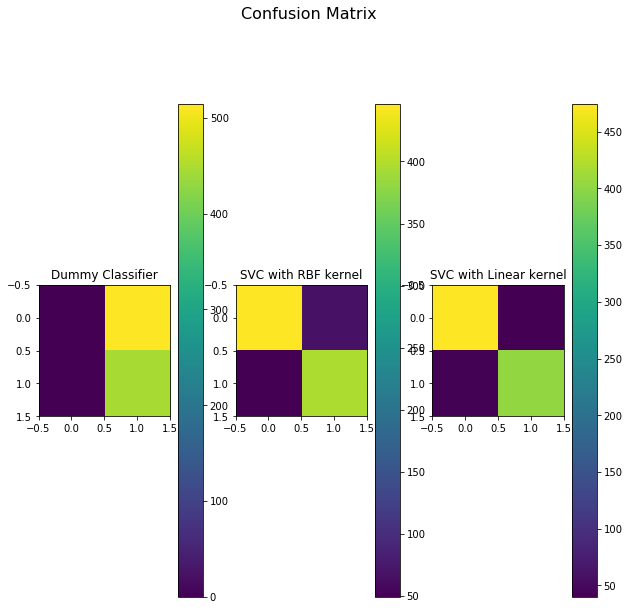

In [20]:
print("Generating predictions from validation data..")

cm1 = confusion_matrix(test_label, pred1)
cm2 = confusion_matrix(test_label, pred2)
cm3 = confusion_matrix(test_label, pred3)


fig, axs = plt.subplots(1, 3 ,figsize=(10, 10))

im1 = axs[0].imshow(cm1)
fig.colorbar(im1, ax=axs[0])
axs[0].set_title("Dummy Classifier")

im2 = axs[1].imshow(cm2)
fig.colorbar(im2, ax=axs[1])
axs[1].set_title("SVC with RBF kernel")

im3 = axs[2].imshow(cm3)
fig.colorbar(im3, ax=axs[2])
axs[2].set_title("SVC with Linear kernel")

fig.suptitle('Confusion Matrix', fontsize=16)

plt.show()

### Evaluation Matrix for each classifier
Calulating evaluation matrix

In [21]:
evaluation = {'Classifier': ['Dummy','SVC w/ RBF kernel','SVC w/ Linear kernel'],
              'Accuracy Score' : [accuracy_score(test_label,pred1),
                                  accuracy_score(test_label, pred2),
                                  accuracy_score(test_label, pred3)],
              'Precision Score' : [precision_score(test_label, pred1),
                                   precision_score(test_label, pred2),
                                   precision_score(test_label, pred3)],
              'Recall Score' : [recall_score(test_label, pred1),
                                recall_score(test_label, pred2),
                                recall_score(test_label, pred3)],
              'F1 Score': [f1_score(test_label, pred1),
                           f1_score(test_label, pred2),
                           f1_score(test_label, pred3)]}

evaldf = DataFrame(evaluation, columns = ['Classifier', 'Accuracy Score', 'Precision Score', 'Recall Score' , 'F1 Score'])

print(evaldf)

             Classifier  Accuracy Score  Precision Score  Recall Score  \
0                 Dummy        0.464583         0.464583      1.000000   
1     SVC w/ RBF kernel        0.878125         0.853763      0.890135   
2  SVC w/ Linear kernel        0.914583         0.909910      0.905830   

   F1 Score  
0  0.634424  
1  0.871570  
2  0.907865  


# IGNORE CODE BELOW

In [22]:
# def bestclf():
#     clf = SVC(C=0.01 , gamma = 0.001, kernel = 'linear')
#     print("Classifier loaded")
#     return clf

#     def train(training_image, training_label):
#         clf.fit(training_image, training_label)
#         print("Training Complete")
#         return clf
    
#     def test(testing_image, testing_label):
#         clfPred = clf.predict(testing_image)
#         print("SVC Classifier with Linear kernel Accuracy: ", accuracy_score(testing_label, clfPred))
#         print(classification_report(testing_label, clfPred))
#         return clf

In [34]:
print(grid_2.best_score_)

0.9255208333333333


In [36]:
from sklearn.svm._base import BaseSVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

class A1(BaseSVC):
    def __init__(self, C=1.0, kernel='linear', gamma='scale'):
        self = SVC(C=C , kernel=kernel, gamma=gamma)
        
        return self
    
#     def __init__(self, C=1.0, kernel='rbf', degree=3, gamma='scale',
#         coef0=0.0, shrinking=True, probability=False,
#         tol=1e-3, cache_size=200, class_weight=None,
#         verbose=False, max_iter=-1, decision_function_shape='ovr',
#         break_ties=False, random_state=None):

#         super().__init__(
#             kernel=kernel, degree=degree, gamma=gamma,
#             coef0=coef0, tol=tol, C=C, nu=0., shrinking=shrinking,
#             probability=probability, cache_size=cache_size,
#             class_weight=class_weight, verbose=verbose, max_iter=max_iter,
#             decision_function_shape=decision_function_shape,
#             break_ties=break_ties,
#             random_state=random_state)
        
    def train(self, X, y=None):
        self.fit(X,y)
        print("done")
        
        return self
    
    def test(self, X, y=None):
        pred = self.predict(X)
        
        print("goodjob")
        return accuracy_score(y,pred)
        

In [37]:
modelA1 = A1

In [38]:
modelA1.train(train_image, train_label)

AttributeError: 'numpy.ndarray' object has no attribute 'fit'

In [23]:
## oldies

In [24]:
# gender_labels = []
# labels_file = open(labels_dir, 'r')
# lines = labels_file.readlines()
# gender_labels = {line.split('\t')[0] : int(line.split('\t')[2]) for line in lines[1:]} #for gender
# # gender_labels = {line.split('\t')[0] : int(line.split('\t')[3]) for line in lines[1:]} #for smiling

# print(gender_labels)